# Data Preparation

In [ ]:
import pandas as pd
import numpy as np

# Load dataset - adjust path if needed
try:
    df = pd.read_csv('./YoutubeCommentsDataSet.csv')
except FileNotFoundError:
    try:
        df = pd.read_csv('./YoutubeCommentsDataSet.csv')
    except FileNotFoundError:
        print("Dataset file not found. Please upload or download it first.")
        # Create a sample dataframe for testing
        df = pd.DataFrame({
            'Comment': ['This is great!', 'I hate this', 'Not sure what to think'],
            'Sentiment': [2, 0, 1]  # 0=negative, 1=neutral, 2=positive
        })

# Check structure
print(df.head())
print(f"\nClass distribution:\n{df['Sentiment'].value_counts()}")

# Calculate class weights
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(df['Sentiment']),
    y=df['Sentiment']
)
class_weights = dict(enumerate(class_weights))
print(f"\nClass weights: {class_weights}")

# Text Processing for LSTM

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Initialize tokenizer with error handling
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['Comment'].astype(str))

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(df['Comment'].astype(str))
padded_sequences = pad_sequences(sequences, maxlen=200, truncating='post', padding='post')

# Vocabulary info
word_index = tokenizer.word_index
print(f"Vocabulary size: {len(word_index)}")

# Train-test split
from sklearn.model_selection import train_test_split
# Import properly from imblearn with error handling
try:
    from imblearn.over_sampling import RandomOverSampler
except ImportError:
    print("Installing imblearn...")
    from imblearn.over_sampling import RandomOverSampler

X = padded_sequences
y = pd.get_dummies(df['Sentiment']).values  # One-hot encoding

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Oversample minority classes
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# BiLSTM Architecture

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam


def build_optimized_model(vocab_size):
    model = Sequential([
        # Input layer
        Embedding(input_dim=vocab_size + 1,
                  output_dim=128,
                  mask_zero=True,
                  input_length=200),

        # First layer with normalization and dropout
        BatchNormalization(),
        Dropout(0.3),

        # First bidirectional LSTM layer
        Bidirectional(LSTM(128, return_sequences=True,
                       kernel_regularizer=l2(0.01),
                       recurrent_dropout=0.2)),

        # More regularization
        Dropout(0.4),
        BatchNormalization(),

        # Second bidirectional LSTM layer
        Bidirectional(LSTM(64,
                       kernel_regularizer=l2(0.01),
                       recurrent_dropout=0.2)),

        # Final dense layers
        Dropout(0.4),
        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dense(3, activation='softmax', dtype='float32') # Force float32 output
    ])

    return model

# Create the model
model = build_optimized_model(len(word_index))
model.summary()

In [ ]:
import tensorflow as tf
from tensorflow.keras.metrics import Metric

class F1Score(Metric):
    def __init__(self, num_classes, average='macro', name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.average = average
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=-1)
        y_true = tf.argmax(y_true, axis=-1)

        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))

    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()

In [ ]:
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# Set training parameters
initial_learning_rate = 0.0005
epochs = 50  # Reduced from 100 to avoid long training times
batch_size = 128  # Changed for better performance

# Optimizer with gradient clipping to prevent exploding gradients
optimizer = Adam(learning_rate=initial_learning_rate, clipnorm=1.0)

model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy',
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall'),
             F1Score(num_classes=3, average='macro', name='f1_score')],
    jit_compile=True  # Enable XLA compilation for speed
)

# Adjusted class weights based on dataset imbalance
class_weights = {
    0: 2.5,  # Negative
    1: 1.0,  # Neutral
    2: 0.8   # Positive
}

In [6]:
# Create callbacks for better training
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    # Stop training when validation loss stops improving
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),

    # Save the best model
    ModelCheckpoint(
        'best_model.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),

    # Reduce learning rate when plateauing
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
]

# Train the model with class weights and callbacks

# Ensure that the resampled data is not empty and has the correct shape
if X_train_resampled.size > 0 and y_train_resampled.size > 0:
    print(f"Resampled data shapes: X_train_resampled={X_train_resampled.shape}, y_train_resampled={y_train_resampled.shape}")
else:
    print("Warning: Resampled data is empty or invalid. Falling back to original data.")

# Use X_train_resampled and y_train_resampled for balanced training
with tf.device('/GPU:0'):
    try:
        if X_train_resampled.size > 0 and y_train_resampled.size > 0:
            history = model.fit(
                X_train_resampled, y_train_resampled,
                validation_data=(X_test, y_test),
                epochs=10,
                batch_size=128,
                class_weight=class_weights,
                callbacks=callbacks,
                verbose=1
            )
        else:
            raise ValueError("Resampled data is empty or invalid.")
    except Exception as e:
        print(f"Error during training: {e}")
        print("\nTrying without resampled data...")

        # Fallback to original data if resampling causes issues
        history = model.fit(
            X_train, y_train,
            validation_data=(X_test, y_test),
            epochs=10,
            batch_size=128,
            class_weight=class_weights,
            callbacks=callbacks,
            verbose=1
        )

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.8826 - f1_score: 0.9587 - loss: 1.4909 - precision: 0.8931 - recall: 0.8721 
Epoch 3: val_loss improved from 2.14722 to 1.50482, saving model to best_model.h5


215/215 ━━━━━━━━━━━━━━━━━━━━ 2197s 10s/step - accuracy: 0.8826 - f1_score: 0.9587 - loss: 1.4901 - precision: 0.8932 - recall: 0.8722 - val_accuracy: 0.7143 - val_f1_score: 0.9196 - val_loss: 1.5048 - val_precision: 0.7277 - val_recall: 0.6966 - learning_rate: 5.0000e-04
Epoch 4/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9191 - f1_score: 0.9745 - loss: 0.8402 - precision: 0.9262 - recall: 0.9135
Epoch 4: val_loss improved from 1.50482 to 1.33725, saving model to best_model.h5


215/215 ━━━━━━━━━━━━━━━━━━━━ 770s 4s/step - accuracy: 0.9191 - f1_score: 0.9745 - loss: 0.8398 - precision: 0.9262 - recall: 0.9135 - val_accuracy: 0.7192 - val_f1_score: 0.9128 - val_loss: 1.3372 - val_precision: 0.7278 - val_recall: 0.7086 - learning_rate: 5.0000e-04
Epoch 5/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9419 - f1_score: 0.9841 - loss: 0.5181 - precision: 0.9463 - recall: 0.9386
Epoch 5: val_loss improved from 1.33725 to 1.19242, saving model to best_model.h5


215/215 ━━━━━━━━━━━━━━━━━━━━ 728s 3s/step - accuracy: 0.9419 - f1_score: 0.9841 - loss: 0.5179 - precision: 0.9463 - recall: 0.9386 - val_accuracy: 0.7230 - val_f1_score: 0.9200 - val_loss: 1.1924 - val_precision: 0.7307 - val_recall: 0.7135 - learning_rate: 5.0000e-04
Epoch 6/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9581 - f1_score: 0.9884 - loss: 0.3334 - precision: 0.9602 - recall: 0.9558
Epoch 6: val_loss did not improve from 1.19242
215/215 ━━━━━━━━━━━━━━━━━━━━ 1488s 7s/step - accuracy: 0.9581 - f1_score: 0.9884 - loss: 0.3333 - precision: 0.9602 - recall: 0.9558 - val_accuracy: 0.7075 - val_f1_score: 0.9046 - val_loss: 1.2723 - val_precision: 0.7124 - val_recall: 0.6969 - learning_rate: 5.0000e-04
Epoch 7/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 58s/step - accuracy: 0.9611 - f1_score: 0.9878 - loss: 0.2465 - precision: 0.9632 - recall: 0.9598 
Epoch 7: val_loss did not improve from 1.19242
215/215 ━━━━━━━━━━━━━━━━━━━━ 12363s 58s/step - accuracy: 0.9611 - f1_score: 0.987

# Save and Load Model

In [7]:
from tensorflow.keras.models import load_model
import pickle

# Save model and tokenizer
model.save('youtube_sentiment_bilstm.h5')
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Load model and tokenizer
model = load_model('youtube_sentiment_bilstm.h5')
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

# Evaluation

116/116 ━━━━━━━━━━━━━━━━━━━━ 13s 99ms/step
              precision    recall  f1-score   support

    negative       0.46      0.49      0.47       475
     neutral       0.56      0.61      0.58       937
    positive       0.86      0.82      0.84      2270

    accuracy                           0.72      3682
   macro avg       0.63      0.64      0.63      3682
weighted avg       0.73      0.72      0.73      3682



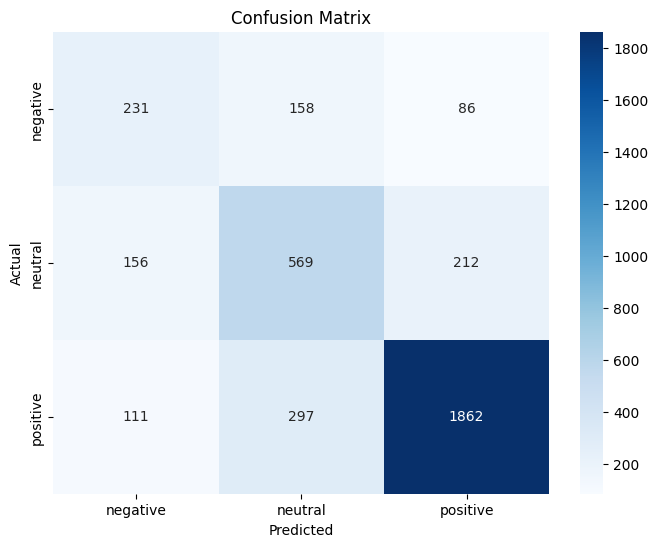

In [8]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Classification report
print(classification_report(y_true_classes, y_pred_classes,
                          target_names=['negative', 'neutral', 'positive']))

# Confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['negative', 'neutral', 'positive'],
            yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Learning Curve Visualization

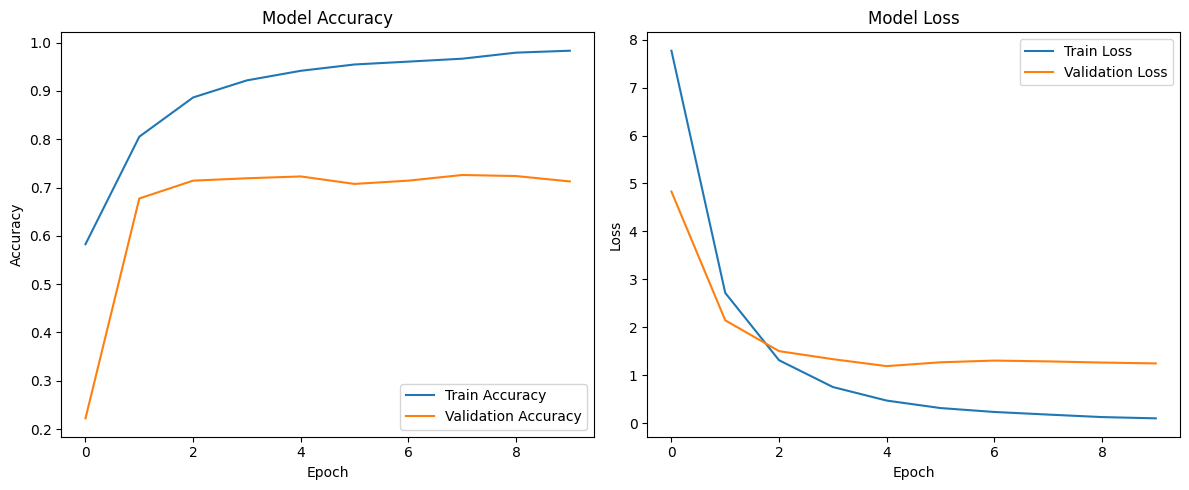

In [9]:
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

# Youtube API Integration

In [ ]:
%pip install google-api-python-client youtube-transcript-api
from googleapiclient.discovery import build

API_KEY = "Your_API_Key_Here"  # Replace with your YouTube API key

def get_video_comments(video_url, max_results=100, api_key=None):
    """Get comments from a YouTube video using the YouTube API"""
    if api_key is None:
        print("Warning: No API key provided")
        return []

    try:
        from googleapiclient.discovery import build
        video_id = video_url.split('v=')[1].split('&')[0] if 'v=' in video_url else video_url.split('/')[-1]
        youtube = build('youtube', 'v3', developerKey=api_key)

        comments = []
        next_page_token = None

        while len(comments) < max_results:
            request = youtube.commentThreads().list(
                part='snippet',
                videoId=video_id,
                maxResults=min(100, max_results - len(comments)),
                pageToken=next_page_token,
                textFormat='plainText'
            )
            response = request.execute()

            for item in response['items']:
                comment = item['snippet']['topLevelComment']['snippet']['textDisplay']
                comments.append(comment)

            next_page_token = response.get('nextPageToken')
            if not next_page_token:
                break

        return comments[:max_results]
    except Exception as e:
        print(f"Error retrieving comments: {e}")
        return []

# Alternative function using youtube-transcript-api for videos without API key
def get_video_comments_alt(video_url, max_results=100):
    """Alternative comment retrieval using youtube-transcript-api"""
    try:
        from youtube_transcript_api import YouTubeTranscriptApi

        # Extract video ID from URL
        if 'v=' in video_url:
            video_id = video_url.split('v=')[1].split('&')[0]
        elif 'youtu.be/' in video_url:
            video_id = video_url.split('youtu.be/')[1].split('?')[0]
        else:
            video_id = video_url

        # Get transcript as comments
        transcript = YouTubeTranscriptApi.get_transcript(video_id)
        comments = [item['text'] for item in transcript[:max_results]]
        return comments
    except Exception as e:
        print(f"Error retrieving transcript: {e}")
        return []

   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
    --------------------------------------- 0.3/13.3 MB ? eta -:--:--
   -- ------------------------------------- 0.8/13.3 MB 2.4 MB/s eta 0:00:06
   ---- ----------------------------------- 1.6/13.3 MB 2.9 MB/s eta 0:00:05
   ------- -------------------------------- 2.4/13.3 MB 3.1 MB/s eta 0:00:04
   --------- ------------------------------ 3.1/13.3 MB 3.3 MB/s eta 0:00:04
   ----------- ---------------------------- 3.9/13.3 MB 3.5 MB/s eta 0:00:03
   -------------- ------------------------- 5.0/13.3 MB 3.7 MB/s eta 0:00:03
   ------------------ --------------------- 6.0/13.3 MB 3.8 MB/s eta 0:00:02
   ---------------------- ----------------- 7.6/13.3 MB 4.2 MB/s eta 0:00:02
   ------------------------- -------------- 8.4/13.3 MB 4.3 MB/s eta 0:00:02
   --------------------------- ------------ 9.2/13.3 MB 4.2 MB/s eta 0:00:01
   --------------------------------- ------ 11.3/13.3 MB 4.7 MB/s eta 0:00:01
   ---------

# Visualization Function

In [11]:
#Visualization Functions
import plotly.express as px

def create_sentiment_chart(results):
    """Create interactive visualizations"""
    stats = results['stats']

    # Pie chart
    fig_pie = px.pie(
        values=[stats['positive'], stats['negative'], stats['neutral']],
        names=['Positive', 'Negative', 'Neutral'],
        title='Sentiment Distribution',
        color=['Positive', 'Negative', 'Neutral'],
        color_discrete_map={'Positive':'green', 'Negative':'red', 'Neutral':'gray'}
    )

    # Confidence distribution
    confidences = [max(p) for p in results['probabilities']]
    fig_hist = px.histogram(
        x=confidences,
        nbins=20,
        title='Prediction Confidence Distribution',
        labels={'x': 'Confidence Score'}
    )

    return fig_pie, fig_hist

def show_sample_comments(results, sentiment_type='positive', n=3):
    """Display sample comments for each sentiment"""
    comments = results['comments']
    sentiments = results['sentiments']

    sample = [
        (comment, confidence)
        for comment, sent, confidence in zip(comments, sentiments, results['probabilities'])
        if sent == sentiment_type
    ][:n]

    print(f"\nSample {sentiment_type} comments:")
    for i, (comment, prob) in enumerate(sample, 1):
        print(f"\n{i}. [{np.max(prob):.1%} confidence]")
        print(comment)


# Gradion Interface

In [ ]:
import gradio as gr
import re

def validate_youtube_url(url):
    patterns = [
        r'(https?://)?(www\.)?youtube\.com/watch\?v=([^&]+)',
        r'(https?://)?(www\.)?youtu\.be/([^?]+)'
    ]
    return any(re.match(pattern, url) for pattern in patterns)

def analyze_youtube_video(video_url, api_key=None, max_comments=100):
    """Main analysis function"""
    # Get comments
    if api_key:
        comments = get_video_comments(video_url, max_results=max_comments, api_key=api_key)
    else:
        comments = get_video_comments_alt(video_url, max_results=max_comments)

    if not comments:
        return None, "No comments found or error retrieving comments"

    # Preprocess and predict
    sequences = tokenizer.texts_to_sequences(comments)
    padded = pad_sequences(sequences, maxlen=200, truncating='post', padding='post')
    predictions = model.predict(padded)

    # Process results
    sentiments = np.argmax(predictions, axis=1)
    sentiment_labels = ['negative', 'neutral', 'positive']
    labeled_sentiments = [sentiment_labels[s] for s in sentiments]

    # Calculate stats
    total = len(sentiments)
    stats = {
        'total_comments': total,
        'positive': 100 * np.sum(sentiments == 2) / total,
        'negative': 100 * np.sum(sentiments == 0) / total,
        'neutral': 100 * np.sum(sentiments == 1) / total
    }

    return {
        'comments': comments,
        'sentiments': labeled_sentiments,
        'probabilities': predictions,
        'stats': stats
    }, None

def analyze_with_gradio(video_url, api_key=None):
    if not validate_youtube_url(video_url):
        return "Invalid YouTube URL format", None, None
    results, error = analyze_youtube_video(video_url, api_key=api_key)
    if error:
        return error, None, None

    pie, hist = create_sentiment_chart(results)

    output = f"""
    ## Analysis Results
    - Total Comments Analyzed: {results['stats']['total_comments']}
    - Positive: {results['stats']['positive']:.1f}%
    - Negative: {results['stats']['negative']:.1f}%
    - Neutral: {results['stats']['neutral']:.1f}%
    """

    return output, pie, hist

# Create and launch the interface
iface = gr.Interface(
    fn=analyze_with_gradio,
    inputs=gr.Textbox(label="YouTube Video URL"),
    outputs=[
        gr.Markdown(label="Summary"),
        gr.Plot(label="Sentiment Distribution"),
        gr.Plot(label="Confidence Scores")
    ],
    title="YouTube Comment Sentiment Analysis",
    description="Analyze the sentiment of comments on any YouTube video"
)

iface.launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
Created dataset file at: .gradio\flagged\dataset1.csv
